#Assignment PrL2
### AE 330 
### Name : V S Harikrishna
### Roll number : 160010054



In [2]:
from __future__ import print_function
import time, copy
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
class AirfoilSpec(object):
    """ Template class for specifying airfoil

        There are methods that give the z-coordinates of the camber & thickness
        distributions, upper & lower surface locations, and derivatives of all
        of these, all taking x-coordinates along the chord as input. All these
        methods work equally well with scalar or 1D numpy array inputs, and
        their outputs are like their inputs. Also, all x- and z-coordinates are
        normalized by the chord length (LE = 0; TE = 1).
    """

    def __init__(self,**kwarg):
        if 'name' in kwarg:
            self.name = kwarg['name']

    # x-derivative of any relevant x-dependent function at a given x-coordinate
    # along chord
    #
    # INPUTS:
    # x_by_c : x-coordinate along chord
    # z      : Handle to function giving variation with x_by_c
    # deltaX : Size of x-step for finite difference approximations
    #
    # OUTPUTS:
    # dz : x-derivative of given z-function
    def dz_dx(self,x_by_c,z,deltaX=0.0001):
        # We start by converting the given x_by_c to a 1D (singleton) numpy
        # array if it is a scalar, since all the subsequent steps are vectorized
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c]) #Create a new singleton array
        else:
            x_copy = x_by_c
        # Find indices of x_copy that are too far to the left (too close to 0) 
        # to pursue 2nd-order accurate central differences
        iL = x_copy < deltaX
        # Find indices of x_copy that are well inside the range [0,1] so as to
        # allow pursuit of 2nd-order accurate central differences
        iM = np.logical_and(x_copy >= deltaX,x_copy <= 1-deltaX)
        # Find indices of x_copy that are too far to the right (too close to 1)
        # to pursue 2nd-order accurate central differences
        iR = x_copy > 1-deltaX
        # Pre-allocate output array like input array
        dz = np.zeros_like(x_copy)
        # Evaluate 1st-order accurate forward differences at leftward points
        dz[iL] = (z(x_copy[iL]+deltaX) -z(x_copy[iL]))/deltaX
        # Evaluate 2nd-order accurate central difference at inner points
        dz[iM] = (z(x_copy[iM]+deltaX) - z(x_copy[iM]-deltaX))/(2*deltaX)
        # Evaluate 1st-order accurate backward differences at rightward points
        dz[iR] = (z(x_copy[iR]) - z(x_copy[iR]-deltaX))/deltaX        
        if singleton:
            dz = dz[0] #Output must be a scalar since input was scalar
        return dz
    
    # Camber distribution of airfoil at a given x-coordinate along chord; this
    # must be coded in the child class
    # def zc_by_c(self,x_by_c):
    #     pass

    # x-derivative of camber distribution at a given x-coordinate along chord
    def dzc_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zc_by_c,deltaX=deltaX)
    
    # Semi-thickness distribution at a given x-coordinate along chord; this
    # must be coded in the child class
    # def zt_by_c(self,x_by_c):
    #     pass
    
    # x-derivative of semi-thickness distribution at a given x-coordinate along
    # chord
    def dzt_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zt_by_c,deltaX=deltaX)

    # z-coordinate of upper surface at a given x-coordinate along chord
    def zu_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) + self.zt_by_c(x_by_c)

    # z-coordinate of lower surface at a given x-coordinate along chord
    def zl_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) - self.zt_by_c(x_by_c)

    # Plot the airfoil geometry, in the supplied axes if given
    def plot(self,axes=None):
        # Create a single plot for both upper and lower surfaces, starting from
        # the LE, going to the TE along the upper surface, and then returning
        # to the LE along the lower surface
        x_by_c = np.linspace(0,1,100)    #x/c for upper surface
        # x/c for lower surface; don't duplicate TE; duplicate LE to close loop
        x_by_c_flip = x_by_c[-2::-1]
        # Final array of x-coordinates to plot
        X = np.concatenate((x_by_c,x_by_c_flip))
        # Final array of z-coordinates to plot
        Z = np.concatenate((self.zu_by_c(x_by_c),self.zl_by_c(x_by_c_flip)))
        if axes is None:
            plt.figure()
            axes = plt.gca()
        axes.plot(X,Z)
        axes.set_xlabel('x/c');  axes.set_ylabel('z/c')
        axes.set_aspect('equal', 'box')
        if hasattr(self,'name'):
            axes.set_title(self.name)
        else:
            axes.set_title('Airfoil geometry')

In [4]:
class NACA4digit(AirfoilSpec):
    """ Implementation of class derived from AirfoilSpec for defining the
        geometry of a NACA 4-digit airfoil

        airfoil = NACA4digit(digits='2412'), or
        airfoil = NACA4digit(mCmbr=0.02,pCmbr=0.4,mThk=0.12)
    """
    def __init__(self,**kwarg):
        if 'digits' in kwarg:
            self.digits = kwarg['digits']
            del kwarg['digits']
            self.mThk = float(self.digits[-2:])/100
            self.mCmbr = float(self.digits[0])/100
            self.pCmbr = float(self.digits[1])/10
        else:
            self.mThk = kwarg['mThk'];   del kwarg['mThk']
            self.mCmbr = kwarg['mCmbr']; del kwarg['mCmbr']
            self.pCmbr = kwarg['pCmbr']; del kwarg['pCmbr']
            self.digits='%02d%d%d'%(self.mCmbr*100,self.pCmbr*10,self.mThk*100)
        self.name = 'NACA '+self.digits
        super().__init__(**kwarg)

    # Camber function of NACA 4-digit airfoil series with maximum fractional
    # camber mCmbr and its fractional position pCmbr available as class
    # attributes already
    def zc_by_c(self,x_by_c):
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c]) #Create a new singleton array
        else:
            x_copy = x_by_c
        cmbr = np.zeros_like(x_copy)
        iL = x_copy <= self.pCmbr
        iT = x_copy > self.pCmbr
        cmbr[iL] = self.mCmbr/self.pCmbr**2*(2*self.pCmbr*x_copy[iL] \
            -np.square(x_copy[iL]))
        cmbr[iT] = self.mCmbr/(1-self.pCmbr)**2 \
            *(1-2*self.pCmbr+2*self.pCmbr*x_copy[iT]-np.square(x_copy[iT]))
        if singleton:
            cmbr = cmbr[0] #Output must be a scalar since input was scalar
        return cmbr

    # Semi-thickness function of NACA 4-digit airfoil series with maximum 
    # fractional thickness mThk available as a class attribute already
    def zt_by_c(self,x_by_c):
        if np.any(x_by_c < 0) or np.any(x_by_c > 1):
            raise Exception('Argument cannot be outside [0, 1]')
        return 5*self.mThk*(0.2969*np.sqrt(x_by_c) - 0.126*x_by_c \
            - 0.3516*np.square(x_by_c) + 0.2843*np.power(x_by_c,3) \
            - 0.1036*np.power(x_by_c,4))

In [5]:
def AirfoilPtsGnrl(datfile):
    """ Extract data of airfoil coordinates from file specified in the Lednicer
        format:
            upper surface points leading edge to trailing edge, followed by
            lower surface points leading edge to trailing edge.
        Code is adapted from https://pypi.org/project/importAirfoil/
        
        INPUTS:
        datfile : Name of file where airfoil coordinates are to be found

        OUTPUTS:
        xu : 1D array of x-coordinates of upper surface
        zu : 1D array of x-coordinates of upper surface
        xl : 1D array of z-coordinates of lower surface
        zl : 1D array of z-coordinates of lower surface
    """
    with open(datfile,'r') as f:
        lines = [lineraw.strip() for lineraw in f]
    iline = -1
    surfaces = []
    current_surface = []

    # Nested function to read and parse a line of text in the file
    def scanf(l):
        import re
        found = re.compile('([-+]?(?:\\d+(?:\\.\\d*)?|\\.\\d+)'\
            +'(?:[eE][-+]?\\d+)?)\\s+([-+]?(?:\\d+(?:\\.\\d*)?|\\.\\d+)'\
            +'(?:[eE][-+]?\\d+)?)').search(l)
        casts = [float, float]
        if found:
            groups = found.groups()
            return tuple([casts[i](groups[i]) for i in range(len(groups))])

    for line in lines: #Read line by line till eof
        iline += 1
        if iline < 2: continue #Skip 2 header lines
        if len(line.strip()) < 3: #Empty line: signals end of a surface definition
            if len(current_surface) > 0: #A surface has been read
                surfaces.append(np.array(current_surface)) #This surface is done
                current_surface = [] #Start a fresh one
        else:
            try:
                xz = scanf(line)
            except Exception as e:
                print("Problem decoding line \"%s\"" % line)
                raise e
            if len(xz) == 2:
                current_surface.append(xz)
            else:
                raise Exception('Too many numerical tokens found in line: '+line)
    # Add last coordinate set we were working on to list of coordinate sets (if
    # file doesn't have blank lines at the end)
    if len(current_surface) > 0: #A surface has been read
        surfaces.append(np.array(current_surface)) #This surface is done
    if len(surfaces) != 2:
        raise Exception('Only two surfaces expected, found %d'%len(surfaces))
    # Separate out upper and lower surfaces
    xzu = surfaces[0]
    xzl = surfaces[1]
    # Return desired arrays
    return xzu[:,0], xzu[:,1], xzl[:,0], xzl[:,1]

In [6]:
class AirfoilFromPoints(AirfoilSpec):
    """ Implementation of class derived from AirfoilSpec for defining the
        geometry of an airfoil from the set of point coordinates of its upper
        and lower surface

        airfoil = AirfoilFromPoints(filename='myAirfoil.dat')
    """
    def __init__(self,**kwarg):
        LednicerFile = kwarg['filename'];   del kwarg['filename']
        super().__init__(**kwarg)
        self.xu, self.zu, self.xl, self.zl = AirfoilPtsGnrl(LednicerFile)
    
    # Get points on upper surface by linear interpolation of specified points
    def zu_by_c(self,x_by_c):
        return np.interp(x_by_c,self.xu,self.zu)
    
    # Get points on lower surface by linear interpolation of specified points
    def zl_by_c(self,x_by_c):
        return np.interp(x_by_c,self.xl,self.zl)
    
    # Find camber from the average of the upper & lower surfaces' z-coordinates
    def zc_by_c(self,x_by_c):
        return (self.zu_by_c(x_by_c)+self.zl_by_c(x_by_c))/2
    
    # Find semi-thickness as half the difference between the upper & lower
    # surfaces' z-coordinates
    def zt_by_c(self,x_by_c):
        return (self.zu_by_c(x_by_c)-self.zl_by_c(x_by_c))/2

In [7]:
def visualizeAirfoil(airfoil):
    """ Function that takes an instantiated object of a class that specifies
        airfoil geometry, and does something with it.

        In this case, it visualizes the airfoil and plots the derivatives of
        its camber and thickness distributions
        
        INPUTS:
        airfoil : Instance of airfoil geometry specification class

        OUTPUTS:
        None
    """
    # Plot the airfoil
    airfoil.plot()
    # Prepare x-coordinate array for plotting derivatives; omit LE where thickness
    # derivative is theoretically infinite for the NACA 4 digit airfoil family
    x_by_c = np.linspace(0,1,100);  x_by_c = x_by_c[1:]
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(x_by_c,airfoil.dzc_dx(x_by_c));
    plt.ylabel('dz_c/dx')
    plt.subplot(2,1,2)
    plt.plot(x_by_c,airfoil.dzt_dx(x_by_c));
    plt.ylabel('dz_t/dx')
    plt.xlabel('x/c');

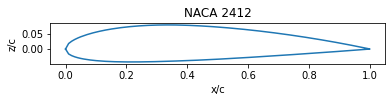

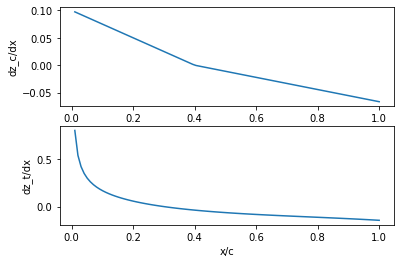

In [8]:
# Visualize a NACA 4-digit airfoil and the derivatives of its camber and
# thickness distributions
naca1 = '2412'
airfoil1 = NACA4digit(digits='2412')
visualizeAirfoil(airfoil1)

In [9]:

# theta = np.linspace(0,pi,100);  theta = theta[1:]
# d_theta = theta[2]-theta[1] 
# x_by_c = 0.5*(1- np.cos(theta))
# dzc_dx = airfoil1.dzc_dx(x_by_c)
# zc_by_c = airfoil1.zc_by_c(x_by_c)

# # print(x_by_c)

In [10]:

# alpha = 5*pi/180
# int_0 = np.sum(dzc_dx*d_theta)
# int_1 = np.sum(dzc_dx*(np.cos(theta)-1)*d_theta)
# int_2 = np.sum(dzc_dx*(np.cos(theta)-np.cos(2*theta))*d_theta)
# c_l = 2*pi*alpha + 2*int_1
# c_m_c4 = -0.5*int_2
# cp_1_u = -2*alpha*np.sqrt((1-x_by_c)/x_by_c)
# cp_1_l = 2*alpha*np.sqrt((1-x_by_c)/x_by_c)
# A_0 = -1/pi*int_0
# A_n = np.zeros(100)
# B_n = np.zeros_like(x_by_c)

# for j in range(1,100):

#   B_n_copy = B_n

#   # for i in range(0,len(x_by_c)):

#   A_n[j] = 2/pi*np.sum(dzc_dx*np.cos(j*theta)*d_theta)

#   B_n = A_n[j]*np.sin(j*theta)

#   B_n = B_n + B_n_copy

# # print(B_n)

# cp_2_u = -2*(A_0*(1+np.cos(theta))/np.sin(theta) + B_n)

# cp_u = cp_1_u + cp_2_u
# cp_l = cp_1_l - cp_2_u


# print(c_m_c4)
# print(c_l)

# plt.plot(x_by_c,cp_u)
# plt.plot(x_by_c,cp_l)

--2022-12-04 17:36:06--  https://m-selig.ae.illinois.edu/ads/coord/rae2822.dat
Resolving m-selig.ae.illinois.edu (m-selig.ae.illinois.edu)... 18.220.149.166
Connecting to m-selig.ae.illinois.edu (m-selig.ae.illinois.edu)|18.220.149.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K)
Saving to: ‘rae2822.dat’

rae2822.dat         100%[===================>]   2.84K  --.-KB/s    in 0s      

2022-12-04 17:36:07 (349 MB/s) - ‘rae2822.dat’ saved [2904/2904]



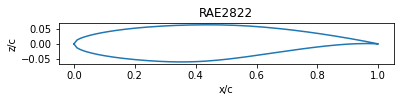

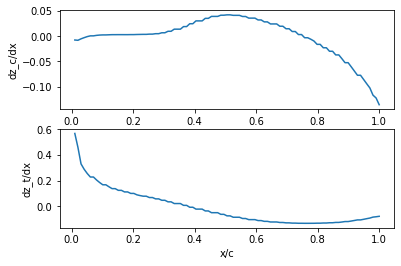

In [11]:
""" Visualize an airfoil like the RAE2822 that is specified by its points
"""
# Get the point coordinates from the excellent U. of Illinois airfoil database
!wget https://m-selig.ae.illinois.edu/ads/coord/rae2822.dat;
# Instantiate the class for specifying the airfoil geometry from the coordinates
# present in this file
airfoil2 = AirfoilFromPoints(filename='rae2822.dat',name='RAE2822')
# Visualize
visualizeAirfoil(airfoil2)

In [12]:
class visuallyCompareAirfoils(object):
    """ Class that has one or more airfoil objects as attributes, may be from
        the time of its constuction, or from later; and does something with them

        In this case it takes two airfoil specification objects, and plots the
        airfoils on the same axes for comparison.
    """
    def __init__(self,airfoilA,airfoilB):
        self.airfoilA = airfoilA
        self.airfoilB = airfoilB
    
    def compare(self):
        self.airfoilA.plot()
        axes = plt.gca()
        self.airfoilB.plot(axes=axes)
        plt.legend([airfoil1.name,airfoil2.name],bbox_to_anchor = (1.03, 0.5));

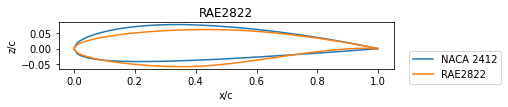

In [13]:
# Compare two airfoils on the same axes
vca = visuallyCompareAirfoils(airfoil1,airfoil2)
vca.compare()

Q2: Method to calculate lift, quarter-chord moment and pressure coefficients

In [36]:
# Calculation of Sectional lift coefficient using Thin airfoil theory:

# Define class thin airfoil soln that takes in airfoil data from code given in 
# PrL2 hint as the argument

class Thin_airfoilsoln(object):

  def __init__(self, airfoil = "2412"  ):

    self.airfoil  = NACA4digit(digits= airfoil) #assign attribute airfoil
    

  
# define a method to numerically integrate a function f (given as a 1D 
# numpy array):
  def integrate(self, f, dx) :
    return np.sum(f*dx)
# method to calculate lift coefficient (c_l), pitching moment coefficient about 
# quarter chord point (c_m_c4) and pressure coefficient (cp_u and cp_l) 
# distribution over the surface 
# along x (normalised with c):
  def calculate(self, alpha, flag) : # method takes the angle of attack alpha and
  #                                    a flag to control whether it should return 
  #                                    a plot of c

    # defining theta as a 1D numpy array between 0 and pi and d_theta for numerical
    #  integration
    theta = np.linspace(0,pi,100)
    theta = theta[1:]
    d_theta = theta[2]-theta[1] 
    # performing coordinate transform form theta to x_by_c :
    x_by_c = 0.5*(1- np.cos(theta))

    # obtaining the slope at airfoil camberline and z coordinate from input :
    dzc_dx = self.airfoil.dzc_dx(x_by_c)
    zc_by_c = self.airfoil.zc_by_c(x_by_c)

    # define vortex sheet density for angle of attack problem (normalised with 
    # free stream velocity V_inf) as gamma_by_V_inf:
    gamma_by_V_inf = 2*alpha*np.sqrt((1-x_by_c)/x_by_c) 

    # integration of slope dz_c/dx with respect to theta for finding vortex
    #  sheet density gamma (normalised with V_inf) for camber problem
    int_0 = self.integrate(dzc_dx, d_theta)

    # integration of dz_c/dx * (cos(theta)-1) with respect to theta for c_l
    int_1 = self.integrate(dzc_dx*(np.cos(theta)-1), d_theta)

    # integration of dz_c/dx * (cos(theta)-cos(2theta)) with respect to theta for c_m_c4
    int_2 = self.integrate(dzc_dx*(np.cos(theta)-np.cos(2*theta)), d_theta)

  # calculation of c_l using solutions of angle of attack problem in 
  # thin airfoil theory:

    # calculate velocity normalised circulation by integrating circulation density:
    int_3 = self.integrate(gamma_by_V_inf*np.sin(theta), d_theta)

    # since the above integral uses chord normalised values for theta and free
    # stream velocity normalised values for vortex density (gamma/V_inf),
    # we can readily calculate c_l


    # calculation of c_l using solutions of angle of attack and camber problem
    c_l = 2*int_3 + 2*int_1

    # calculation of c_m_c4 using solutions of angle of attack and camber problem
    c_m_c4 = -0.5*int_2

    # calculation of c_p using solutions of angle of attack and camber problem

    # first, calculating contribution of pressure coefficient due to angle of 
    # attack problem on both upper and lower surface: 
    cp_1_u = -2*alpha*np.sqrt((1-x_by_c)/x_by_c)
    cp_1_l = 2*alpha*np.sqrt((1-x_by_c)/x_by_c)

    # for the camber problem contribution towards c_p we compute it as gamma/V_infinity.

    # finding coefficients for gamma/V_infinity: 
    A_0 = -1/pi*int_0     # already calculated before

    A_n = np.zeros(100)   # array for storing values of each coefficient A_n 
    #                     (we consider only first 100 terms)


    B_n = np.zeros_like(x_by_c) # array for storing values of summation of 
    #                             first hundred terms of the expression for 
    #                             gamma/V_infinity


    # for obtaining the summation of 100 terms
    for j in range(1,100):

      B_n_copy = B_n

      A_n[j] = 2/pi*np.sum(dzc_dx*np.cos(j*theta)*d_theta)

      B_n = A_n[j]*np.sin(j*theta)

      B_n = B_n + B_n_copy

    # camber problem contribution towards c_p obtained as:
    cp_2_u = -2*(A_0*(1+np.cos(theta))/np.sin(theta) + B_n)

    
    # since equation is linear in gamma, we can add both solutions to get total
    # contribution to cp on upper and lower surface:
    cp_u = cp_1_u + cp_2_u
    cp_l = cp_1_l - cp_2_u

    # plotting function controlled by flag:
    if flag == 1:
      
      plt.plot(x_by_c,cp_u, label= "upper surface")
      plt.plot(x_by_c,cp_l, label = "lower surface")
      plt.title("c_p vs x/c plot")
      plt.xlabel("x/c")
      plt.ylabel("c_p")
      plt.legend()
      

    
    # returning values of c_l, c_m_c4, cp_l and cp_u. cp_l and cp_u are 1D numpy arrays
    return c_l, c_m_c4, cp_l, cp_u

  
  # for repeated calculations of c_l and c_m_c4, define a method to only 
  # calculate c_l and c_m_c4 and not cp_u and cp_l

  def quick_calculate(self, alpha, flag) : # method takes the angle of attack alpha and
  #                                    a flag to control whether it should return 
  #                                    a plot of c

    # defining theta as a 1D numpy array between 0 and pi and d_theta for numerical
    #  integration
    theta = np.linspace(0,pi,100)
    theta = theta[1:]
    d_theta = theta[2]-theta[1] 
    # performing coordinate transform form theta to x_by_c :
    x_by_c = 0.5*(1- np.cos(theta))

    # obtaining the slope at airfoil camberline and z coordinate from input :
    dzc_dx = self.airfoil.dzc_dx(x_by_c)
    zc_by_c = self.airfoil.zc_by_c(x_by_c)

    # integration of slope dz_c/dx with respect to theta for finding vortex sheet density
    int_0 = self.integrate(dzc_dx, d_theta)

    # integration of dz_c/dx * (cos(theta)-1) with respect to theta for c_l
    int_1 = self.integrate(dzc_dx*(np.cos(theta)-1), d_theta)

    # integration of dz_c/dx * (cos(theta)-cos(2theta)) with respect to theta for c_m_c4
    int_2 = self.integrate(dzc_dx*(np.cos(theta)-np.cos(2*theta)), d_theta)

    # calculation of c_l using solutions of angle of attack and camber problem
    c_l = 2*pi*alpha + 2*int_1

    # calculation of c_m_c4 using solutions of angle of attack and camber problem
    c_m_c4 = -0.5*int_2


    return c_l, c_m_c4


0.23202719579016035 -0.05417642175470456


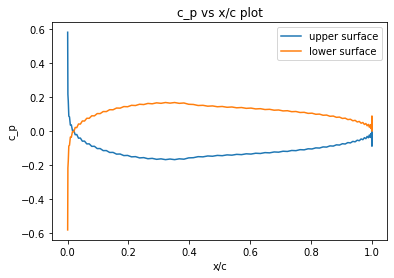

In [37]:
airfoil_A = Thin_airfoilsoln("2412")
c_l, c_m_c4, cp_l, cp_u = airfoil_A.calculate(alpha=0, flag = 1)
print(c_l, c_m_c4)




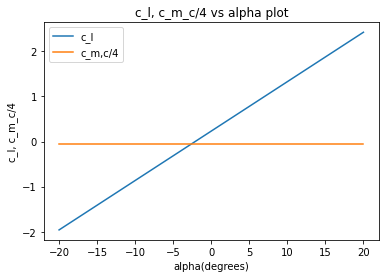

In [33]:
# program for running the above code repeatedly to plot cl vs alpha and 
# c_m_c4 vs alpha curves

alpha_values = np.linspace(-20*pi/180, 20*pi/180, 160)
c_l_values = np.zeros_like(alpha_values)
c_m_c4_values = np.zeros_like(alpha_values)
airfoil_B = Thin_airfoilsoln("2412")

for i in range (0, len(alpha_values)) :
  c_l_values[i], c_m_c4_values[i] = airfoil_B.quick_calculate(alpha = alpha_values[i], flag = 0)
  
plt.plot(180*alpha_values/pi, c_l_values,label= "c_l")
plt.plot(180*alpha_values/pi, c_m_c4_values,label= "c_m,c/4")
plt.title("c_l, c_m_c/4 vs alpha plot")
plt.xlabel("alpha(degrees)")
plt.ylabel("c_l, c_m_c/4")
plt.legend()


Q 3: Comparison with experimental data:

Experimental data was obtained from http://airfoiltools.com/polar/csv?polar=xf-naca2412-il-1000000 .

Using 36 points from obtained experimental data, we compare the $c_{l}-\alpha$ curve and $c_{m,c/4}-\alpha$ curves

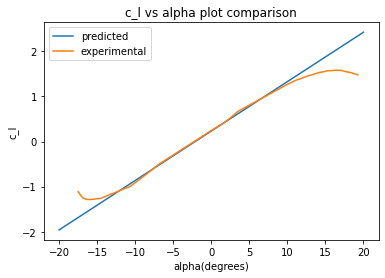

In [31]:
expt_values_alpha = np.array([ -17.5,
-17.25,
-17,
-16.75,
-16.5,
-16.25,
-16,
-15.75,
-15.5,
-15.25,
-15,
-14.75,
-14.5,
-14.25,
-14,
-13.75,
-13.5,
-13.25,
-13,
-12.75,
-12.5,
-12.25,
-12,
-11.75,
-11.5,
-11.25,
-11,
-10.75,
-10.5,
-10.25,
-10,
-9.75,
-9.5,
-9.25,
-9,
-8.75,
-8.5,
-8.25,
-8,
-7.75,
-7.5,
-7.25,
-7,
-6.75,
-6.5,
-6.25,
-6,
-5.75,
-5.5,
-5.25,
-5,
-4.75,
-4.5,
-4,
-3.75,
-3.5,
-3.25,
-3,
-2.75,
-2.5,
-2.25,
-2,
-1.75,
-1.5,
-1.25,
-1,
-0.75,
-0.5,
-0.25,
0,
0.25,
0.5,
0.75,
1,
1.25,
1.5,
1.75,
2,
2.75,
3,
3.25,
3.5,
3.75,
4,
4.25,
4.5,
4.75,
5,
5.25,
5.5,
5.75,
6,
6.25,
6.5,
6.75,
7,
7.25,
7.5,
7.75,
8,
8.25,
8.5,
8.75,
9,
9.25,
9.5,
9.75,
10,
10.25,
10.5,
10.75,
11,
11.25,
11.5,
11.75,
12,
12.25,
12.5,
12.75,
13,
13.25,
13.5,
13.75,
14,
14.25,
14.5,
14.75,
15,
15.25,
15.5,
15.75,
16,
16.25,
16.5,
16.75,
17,
17.25,
17.5,
17.75,
18,
18.25,
18.5,
18.75,
19,
19.25,])


expt_values_cl = np.array([-1.1118,
-1.1738,
-1.2296,
-1.2629,
-1.279,
-1.2852,
-1.2869,
-1.2853,
-1.2815,
-1.2755,
-1.2674,
-1.2667,
-1.2585,
-1.2429,
-1.2251,
-1.2068,
-1.1881,
-1.169,
-1.1561,
-1.1417,
-1.1239,
-1.1058,
-1.0881,
-1.0704,
-1.0519,
-1.0327,
-1.0222,
-1.0046,
-0.9766,
-0.9448,
-0.9125,
-0.8793,
-0.8484,
-0.8172,
-0.7863,
-0.7542,
-0.7211,
-0.687,
-0.652,
-0.6166,
-0.585,
-0.5532,
-0.5207,
-0.4884,
-0.4627,
-0.4342,
-0.4073,
-0.3804,
-0.3538,
-0.3274,
-0.3006,
-0.2737,
-0.2465,
-0.1918,
-0.1645,
-0.1372,
-0.11,
-0.0825,
-0.0552,
-0.0277,
-0.0003,
0.0272,
0.0546,
0.0819,
0.1092,
0.1362,
0.1632,
0.1903,
0.2173,
0.2442,
0.2709,
0.2968,
0.3217,
0.3469,
0.3722,
0.3979,
0.425,
0.4549,
0.5582,
0.5945,
0.6318,
0.6686,
0.6918,
0.7153,
0.7389,
0.7624,
0.7858,
0.8089,
0.8319,
0.8552,
0.8784,
0.9016,
0.9251,
0.9483,
0.971,
0.9944,
1.0179,
1.0414,
1.0644,
1.0885,
1.1111,
1.1353,
1.1585,
1.1801,
1.2032,
1.2262,
1.2485,
1.2696,
1.2881,
1.309,
1.3299,
1.35,
1.3684,
1.3833,
1.3931,
1.4114,
1.4284,
1.4446,
1.4595,
1.4699,
1.4815,
1.4967,
1.5106,
1.5228,
1.5311,
1.5386,
1.5499,
1.5597,
1.5675,
1.5712,
1.5723,
1.5775,
1.5806,
1.582,
1.5815,
1.5784,
1.5716,
1.5603,
1.5483,
1.5415,
1.5328,
1.5214,
1.5083,
1.4942,
1.4781,
])
plt.plot(180*alpha_values/pi, c_l_values, label= "predicted")

plt.plot(expt_values_alpha, expt_values_cl, label = "experimental")

plt.title("c_l vs alpha plot comparison")
plt.xlabel("alpha(degrees)")
plt.ylabel("c_l")
plt.legend()



Q4: Detailed comparison with experimental values

Airfoil chosen : NACA 2412

Since thin airfoil theory assumes that region of flow affected by viscosity is small, we choose a high Reynold's number ( $R_{e}$ = 1000000 ) flow.

Experimental data was obtained from http://airfoiltools.com/polar/csv?polar=xf-naca2412-il-1000000 .

A .csv file is attached with the assignment for reference


a) Comparison of lift slopes :





In [18]:
Slope = np.zeros_like(c_l_values)
Slope_exp = np.zeros_like(expt_values_cl)

for i in range(0,len(Slope)-1) :
  Slope =  (c_l_values[i+1]-c_l_values[i])/(180/pi*(alpha_values[i+1]- alpha_values[i]))
Slope_TAtheory = np.average(Slope) 


 
# Slope_exp[:-1] #to avoid error due to last zero value
Slope_Exp = 0.107917094 # calculated from attached excel sheet using c_l values
                        # for alpha between -10 degrees to +10 degrees

print(Slope_TAtheory)


0.10966227112321542


We see that the lift slope agrees very closely in the linear region. This can be explained due to the fact that for high Reynold's number, the region where viscous effects dominate is very small. 
It is also evident that our data fails to agree at high angle of attack as the fundamental assumption of minimal perturbation of flow breaks down and flow separation occurs due to viscous effects. 

b) Comparison of zero lift angle of attack $\alpha_{L=0}$

In [19]:
iR = c_l_values > 0
iL = c_l_values < 0

alpha_R = alpha_values[iR]
alpha_L = alpha_values[iL]

alpha_L0_theory = 0.5*(180/pi*(alpha_R[0] + alpha_L[-1]))
print(alpha_L0_theory)

alpha_L0_expt = -2.247272727 # calculated from attached excel sheet



-2.0125786163522035


Our data is offset by about 10%. This can be attibuted to viscous effects in the experinmental flow.
(Experimental data considers viscosity)

c) Comparing $c_{m,c/4}$ :

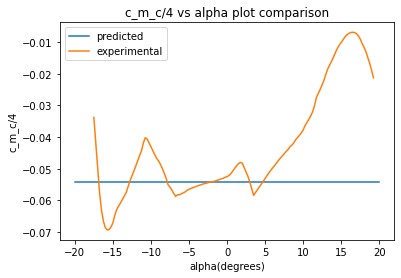

In [38]:
expt_values_alpha = np.array([ -17.5,
-17.25,
-17,
-16.75,
-16.5,
-16.25,
-16,
-15.75,
-15.5,
-15.25,
-15,
-14.75,
-14.5,
-14.25,
-14,
-13.75,
-13.5,
-13.25,
-13,
-12.75,
-12.5,
-12.25,
-12,
-11.75,
-11.5,
-11.25,
-11,
-10.75,
-10.5,
-10.25,
-10,
-9.75,
-9.5,
-9.25,
-9,
-8.75,
-8.5,
-8.25,
-8,
-7.75,
-7.5,
-7.25,
-7,
-6.75,
-6.5,
-6.25,
-6,
-5.75,
-5.5,
-5.25,
-5,
-4.75,
-4.5,
-4,
-3.75,
-3.5,
-3.25,
-3,
-2.75,
-2.5,
-2.25,
-2,
-1.75,
-1.5,
-1.25,
-1,
-0.75,
-0.5,
-0.25,
0,
0.25,
0.5,
0.75,
1,
1.25,
1.5,
1.75,
2,
2.75,
3,
3.25,
3.5,
3.75,
4,
4.25,
4.5,
4.75,
5,
5.25,
5.5,
5.75,
6,
6.25,
6.5,
6.75,
7,
7.25,
7.5,
7.75,
8,
8.25,
8.5,
8.75,
9,
9.25,
9.5,
9.75,
10,
10.25,
10.5,
10.75,
11,
11.25,
11.5,
11.75,
12,
12.25,
12.5,
12.75,
13,
13.25,
13.5,
13.75,
14,
14.25,
14.5,
14.75,
15,
15.25,
15.5,
15.75,
16,
16.25,
16.5,
16.75,
17,
17.25,
17.5,
17.75,
18,
18.25,
18.5,
18.75,
19,
19.25,])





expt_values_c_m_c4 = np.array( [-0.0338,
-0.0418,
-0.0502,
-0.0575,
-0.063,
-0.0665,
-0.0685,
-0.0693,
-0.0692,
-0.0684,
-0.0671,
-0.0647,
-0.0629,
-0.0618,
-0.0608,
-0.0597,
-0.0586,
-0.0575,
-0.0556,
-0.0538,
-0.0523,
-0.0508,
-0.0492,
-0.0475,
-0.0459,
-0.0444,
-0.0419,
-0.0402,
-0.0406,
-0.0418,
-0.043,
-0.0443,
-0.0455,
-0.0467,
-0.0475,
-0.0486,
-0.0499,
-0.0514,
-0.053,
-0.055,
-0.0558,
-0.0567,
-0.0578,
-0.0587,
-0.0582,
-0.0582,
-0.0579,
-0.0576,
-0.0573,
-0.0568,
-0.0565,
-0.0562,
-0.056,
-0.0555,
-0.0553,
-0.0551,
-0.0549,
-0.0547,
-0.0546,
-0.0544,
-0.0542,
-0.0541,
-0.054,
-0.0538,
-0.0536,
-0.0534,
-0.0532,
-0.053,
-0.0527,
-0.0525,
-0.0521,
-0.0516,
-0.0507,
-0.0499,
-0.0491,
-0.0484,
-0.048,
-0.0482,
-0.0524,
-0.0542,
-0.0563,
-0.0584,
-0.0575,
-0.0566,
-0.0557,
-0.0549,
-0.054,
-0.0531,
-0.0522,
-0.0513,
-0.0505,
-0.0497,
-0.049,
-0.0482,
-0.0474,
-0.0467,
-0.046,
-0.0453,
-0.0446,
-0.044,
-0.0431,
-0.0426,
-0.0419,
-0.0409,
-0.0402,
-0.0395,
-0.0387,
-0.0378,
-0.0364,
-0.0354,
-0.0344,
-0.0333,
-0.032,
-0.0301,
-0.0275,
-0.0262,
-0.0249,
-0.0235,
-0.022,
-0.0201,
-0.0184,
-0.0172,
-0.016,
-0.0147,
-0.0133,
-0.012,
-0.011,
-0.0101,
-0.0093,
-0.0084,
-0.0077,
-0.0073,
-0.007,
-0.0069,
-0.007,
-0.0073,
-0.008,
-0.009,
-0.0104,
-0.0116,
-0.013,
-0.0148,
-0.0167,
-0.0189,
-0.0213])

plt.plot(180*alpha_values/pi, c_m_c4_values, label = "predicted")

plt.plot(expt_values_alpha, expt_values_c_m_c4, label= "experimental")

plt.title("c_m_c/4 vs alpha plot comparison")
plt.xlabel("alpha(degrees)")
plt.ylabel("c_m_c/4")
plt.legend()


We see that our prediction for c_m at $x = c/4$ does not agree closely with experimental data even in the linear regime for small angle of attack. This is due to contribution of thickness being ignored and due to the fact that the aerodynamic centre shifts in actuality as opposed to being fixed at $x = c/4$

d) Plot comparison between $c_{p}$ distribution with experimental data:

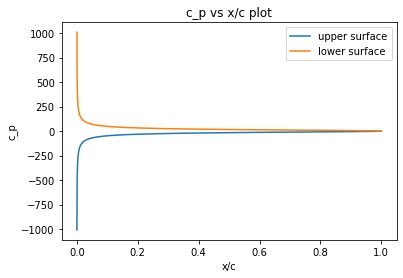

In [39]:
airfoil_C = Thin_airfoilsoln("2412")
c_l, c_m_c4, cp_l, cp_u = airfoil_C.calculate(alpha=8, flag = 1)



I could not obtain experimental data.